=== Overall Metrics ===


,Metric,Value
0,total_responses,90.000000
1,responses_with_links,74.000000
2,total_extracted_links,642.000000
3,avg_links_per_response,7.133333
4,median_links_per_response,8.000000
5,unique_domains,333.000000



=== Top 10 Domains ===


,Domain,Count
0,youtube.com,10
1,linkedin.com,9
2,reddit.com,7
3,shopify.com,6
4,bloggerspassion.com,6
5,forbes.com,5
6,elementor.com,5
7,targetinternet.com,4
8,nytimes.com,4
9,pubmed.ncbi.nlm.nih.gov,4



=== TLD Distribution ===


,TLD,Count,Pct
0,.com,333,71.922246
1,.org,39,8.423326
2,.gov,13,2.807775
3,.uk,7,1.511879
4,.is,6,1.295896
5,.io,6,1.295896
6,.de,5,1.079914
7,.ai,5,1.079914
8,.edu,4,0.863931
9,.vn,4,0.863931



=== Avg Links per System ===


,count,mean,median
system,,,
perplexity,30,10.800000,10.0
chatgpt,30,6.833333,8.0
copilot,30,3.766667,4.0


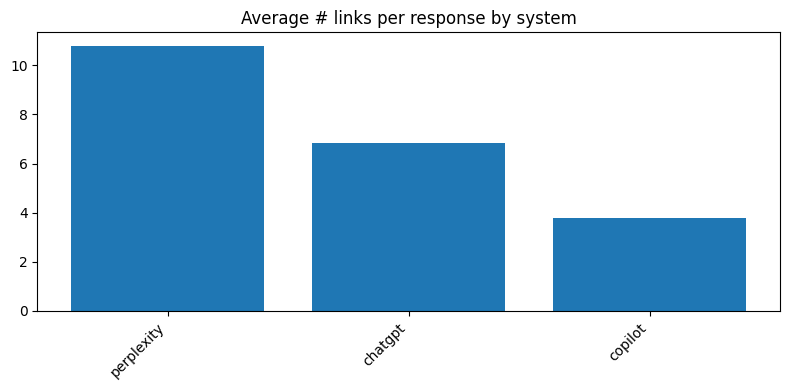

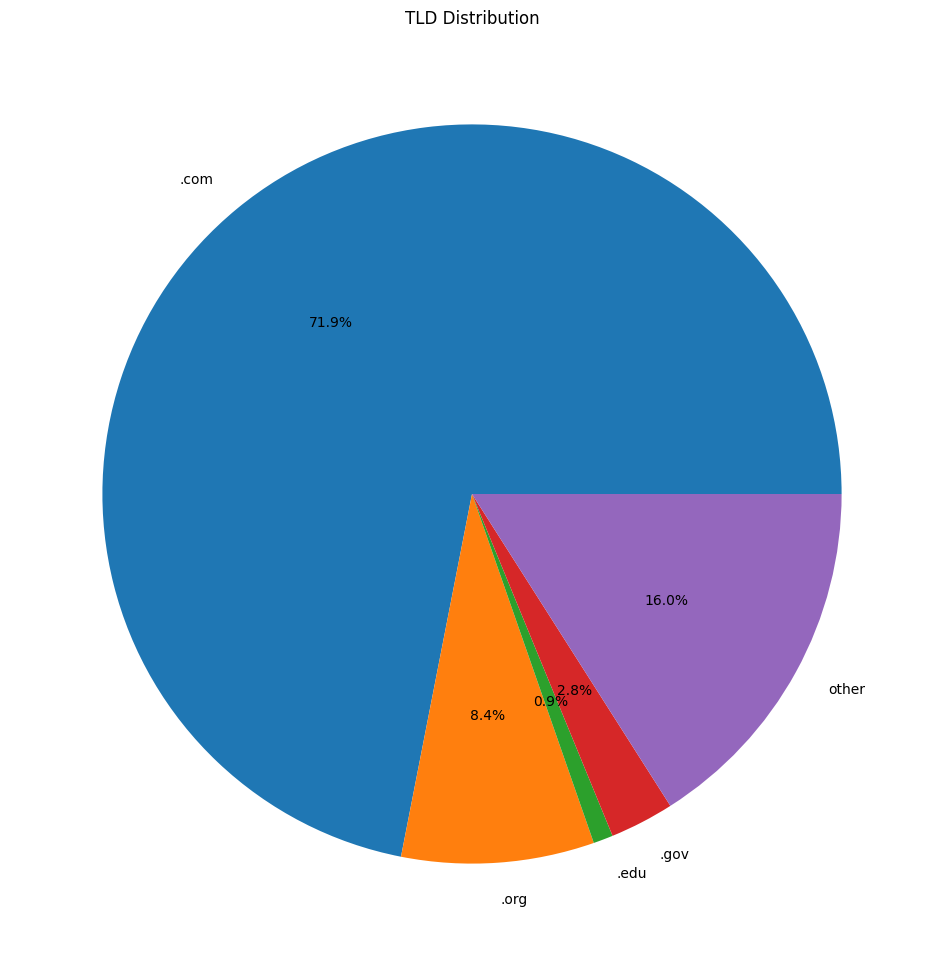

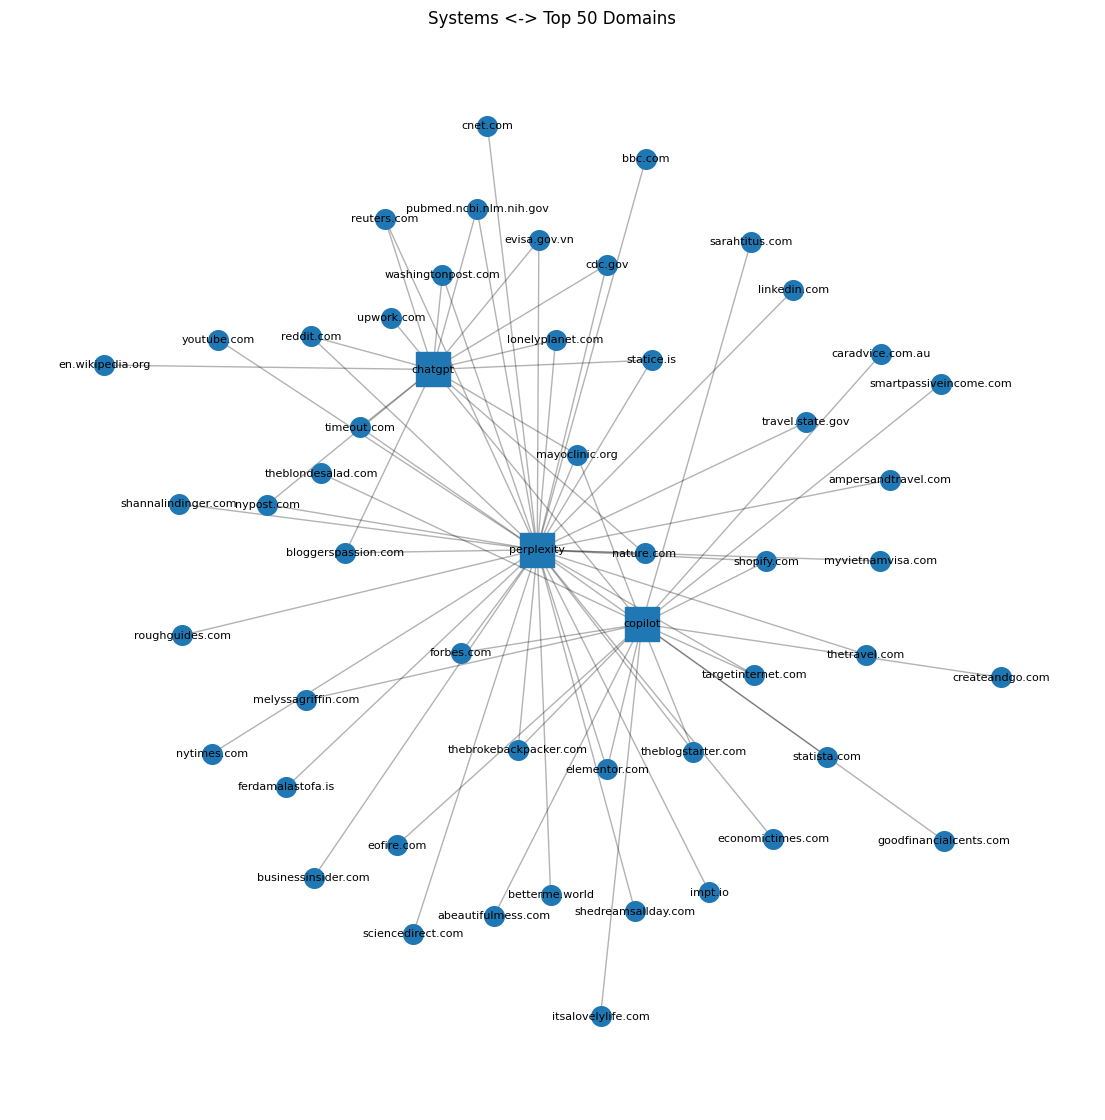

Saved processed outputs and visualizations.


In [ ]:
# llm_citation_analysis_full_grouped.py
# Dependencies: pandas, matplotlib, networkx, urllib

import re, os
import pandas as pd
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import networkx as nx

# ----------------------------
# Paths
# ----------------------------
FILE_PATH = "data/Ranklab - LLM Citation Researrch - Sheet1.csv"
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ----------------------------
# Load data
# ----------------------------
df = pd.read_csv(FILE_PATH)

# ----------------------------
# URL extraction
# ----------------------------
url_text_cols = [c for c in ["cited_url", "... links", "cited_urls", "links", "response", "answer", "text"] if c in df.columns]
url_re = re.compile(r"https?://[^\s)>\"]+")

def extract_urls(text):
    if not isinstance(text, str): return []
    urls = url_re.findall(text)
    return [u.rstrip(".,;:')]>\"") for u in urls]

def gather_urls_from_row(row):
    urls = []
    for c in url_text_cols:
        v = row.get(c, "")
        if isinstance(v, str) and v.strip():
            if v.startswith("http://") or v.startswith("https://"):
                parts = re.split(r"[\s,;]+", v)
                for p in parts:
                    if p.startswith("http://") or p.startswith("https://"):
                        urls.append(p.rstrip(".,;:')]>\""))
            else:
                urls.extend(extract_urls(v))
    seen = set(); out = []
    for u in urls:
        if u not in seen:
            seen.add(u)
            out.append(u)
    return out

# ----------------------------
# Group by prompt and system
# ----------------------------
group_cols = ["prompt"]
if "system" in df.columns:
    group_cols.append("system")

grouped = df.groupby(group_cols, as_index=False).agg({
    **{c: "first" for c in df.columns if c not in group_cols},
})

# ----------------------------
# Use n. of links if available, else extract URLs
# ----------------------------
if "n. of links" in grouped.columns:
    grouped["_num_urls"] = pd.to_numeric(grouped["n. of links"], errors='coerce').fillna(0).astype(int)
else:
    grouped["_extracted_urls"] = grouped.apply(gather_urls_from_row, axis=1)
    grouped["_num_urls"] = grouped["_extracted_urls"].apply(len)

# ----------------------------
# Domain and TLD extraction
# ----------------------------
def domain_from_url(url):
    try:
        p = urlparse(url)
        domain = p.netloc.lower().split(':')[0]
        if domain.startswith("www."):
            domain = domain[4:]
        return domain
    except:
        return None

if "_extracted_urls" not in grouped.columns:
    grouped["_extracted_urls"] = grouped.apply(gather_urls_from_row, axis=1)

grouped["_domains"] = grouped["_extracted_urls"].apply(lambda urls: [domain_from_url(u) for u in urls])
exploded = grouped.explode("_domains").rename(columns={"_domains":"domain_exploded"})
exploded = exploded[~exploded["domain_exploded"].isna() & (exploded["domain_exploded"]!="")]
exploded["_tld"] = exploded["domain_exploded"].apply(lambda d: ("." + d.split(".")[-1]) if isinstance(d, str) and "." in d else "other")

# ----------------------------
# Overall Metrics
# ----------------------------
metrics = {
    "total_responses": len(grouped),
    "responses_with_links": int((grouped["_num_urls"]>0).sum()),
    "total_extracted_links": int(grouped["_num_urls"].sum()),
    "avg_links_per_response": float(grouped["_num_urls"].mean()),
    "median_links_per_response": float(grouped["_num_urls"].median()),
    "unique_domains": int(exploded["domain_exploded"].nunique())
}

print("=== Overall Metrics ===")
metrics_df = pd.DataFrame(list(metrics.items()), columns=["Metric","Value"])
display(metrics_df)

# ----------------------------
# Top 10 Domains
# ----------------------------
print("\n=== Top 10 Domains ===")
domain_counts = exploded["domain_exploded"].value_counts().head(10).reset_index()
domain_counts.columns = ["Domain","Count"]
display(domain_counts)

# ----------------------------
# TLD distribution
# ----------------------------
tld_counts = exploded["_tld"].value_counts().reset_index()
tld_counts.columns = ["TLD","Count"]
tld_counts["Pct"] = tld_counts["Count"] / tld_counts["Count"].sum() * 100
print("\n=== TLD Distribution ===")
display(tld_counts)

# ----------------------------
# Avg links per system
# ----------------------------
if "system" in grouped.columns:
    avg_by_system = grouped.groupby("system")["_num_urls"].agg(["count","mean","median"]).sort_values("mean", ascending=False)
    print("\n=== Avg Links per System ===")
    display(avg_by_system)
    
    plt.figure(figsize=(8,4))
    plt.bar(avg_by_system.index.astype(str), avg_by_system["mean"])
    plt.xticks(rotation=45, ha='right')
    plt.title("Average # links per response by system")
    plt.tight_layout()
    plt.show()

# ----------------------------
# Pie chart for TLDs
# ----------------------------
tld_summary = exploded["_tld"].value_counts()
tld_plot_vals = [
    tld_summary.get(".com",0),
    tld_summary.get(".org",0),
    tld_summary.get(".edu",0),
    tld_summary.get(".gov",0),
    tld_summary.sum() - sum([tld_summary.get(x,0) for x in [".com",".org",".edu",".gov"]])
]
tld_plot_labels = [".com",".org",".edu",".gov","other"]
plt.figure(figsize=(12,12))
plt.pie(tld_plot_vals, labels=tld_plot_labels, autopct="%1.1f%%")
plt.title("TLD Distribution")
plt.show()

# ----------------------------
# Network graph: Systems <-> Top 50 Domains
# ----------------------------
top_dom_list = exploded["domain_exploded"].value_counts().head(50).index.tolist()
systems = grouped["system"].dropna().unique().tolist()
G = nx.Graph()
G.add_nodes_from(systems, bipartite=0)
G.add_nodes_from(top_dom_list, bipartite=1)

for idx, row in grouped.iterrows():
    s = row.get("system", "unknown")
    for d in row["_domains"]:
        if d in top_dom_list:
            G.add_edge(s, d)

plt.figure(figsize=(14,14))
pos = nx.spring_layout(G, k=0.6, seed=42)
nx.draw_networkx_nodes(G, pos, nodelist=systems, node_shape='s', node_size=600)
nx.draw_networkx_nodes(G, pos, nodelist=top_dom_list, node_shape='o', node_size=200)
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.axis('off')
plt.title("Systems <-> Top 50 Domains")
plt.show()

# ----------------------------
# Save processed files
# ----------------------------
grouped.to_csv(f"{OUTPUT_DIR}/processed_responses_with_urls.csv", index=False)
exploded.to_csv(f"{OUTPUT_DIR}/exploded_domain_rows.csv", index=False)
print("Saved processed outputs and visualizations.")

=== Top Domains per Niche ===


,niche,domain_exploded,count
38,Entrepreneurship,linkedin.com,8
6,Entrepreneurship,bloggerspassion.com,6
82,Entrepreneurship,shopify.com,6
22,Entrepreneurship,elementor.com,5
87,Entrepreneurship,targetinternet.com,4
92,Entrepreneurship,theblogstarter.com,4
113,Entrepreneurship,youtube.com,4
80,Entrepreneurship,shedreamsallday.com,3
101,Entrepreneurship,upwork.com,3
0,Entrepreneurship,abeautifulmess.com,2


=== TLD Distribution per Niche ===


,niche,_tld,count,pct
0,Entrepreneurship,.ai,2,1.162791
1,Entrepreneurship,.app,1,0.581395
2,Entrepreneurship,.au,2,1.162791
3,Entrepreneurship,.co,1,0.581395
4,Entrepreneurship,.com,146,84.883721
5,Entrepreneurship,.de,2,1.162791
6,Entrepreneurship,.dev,1,0.581395
7,Entrepreneurship,.digital,1,0.581395
8,Entrepreneurship,.gh,1,0.581395
9,Entrepreneurship,.io,2,1.162791


=== Avg Links per Niche ===


,count,mean,median
niche,,,
travel,30,7.800000,9.0
Entrepreneurship,30,7.566667,7.0
HEALTH,30,6.033333,7.5


/var/folders/tv/thdvvbln0lz5ywll1jygc34r0000gn/T/ipykernel_4044/1339424785.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="domain_exploded", y="count", palette="viridis")


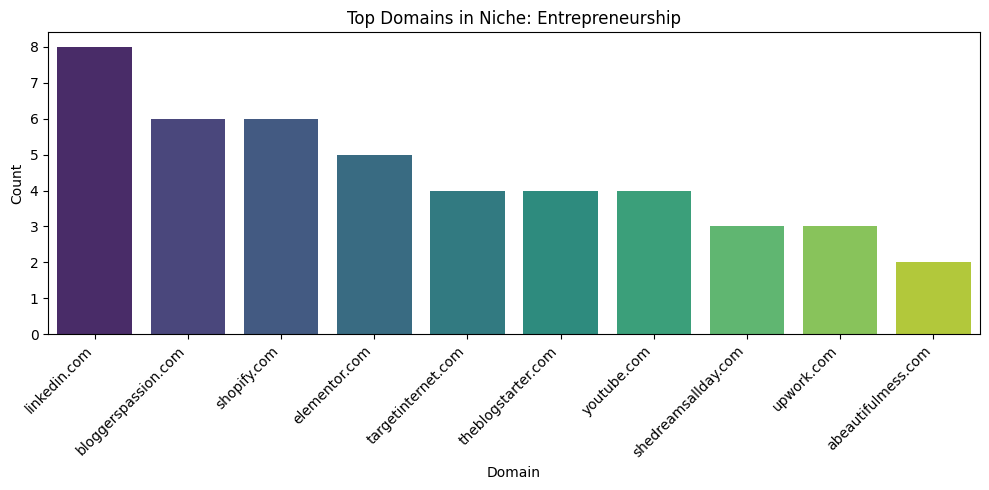

/var/folders/tv/thdvvbln0lz5ywll1jygc34r0000gn/T/ipykernel_4044/1339424785.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="domain_exploded", y="count", palette="viridis")


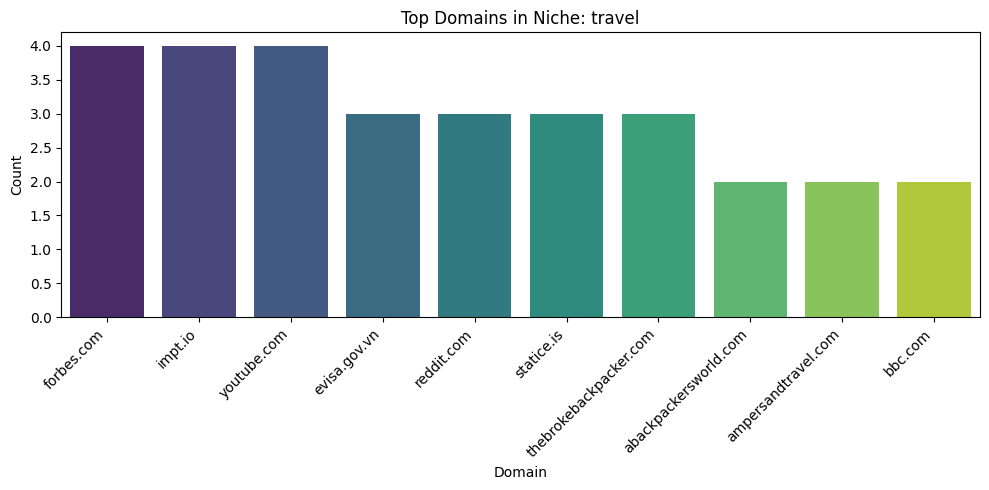

/var/folders/tv/thdvvbln0lz5ywll1jygc34r0000gn/T/ipykernel_4044/1339424785.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="domain_exploded", y="count", palette="viridis")


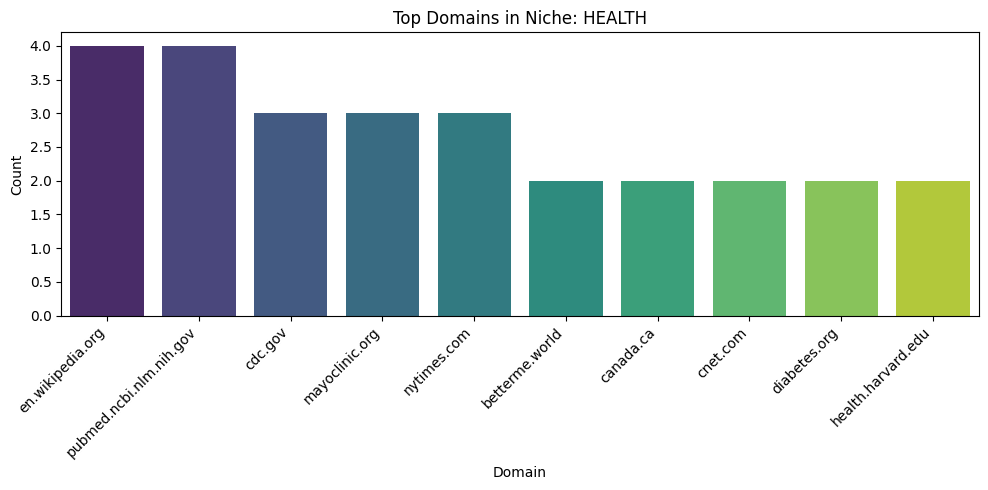

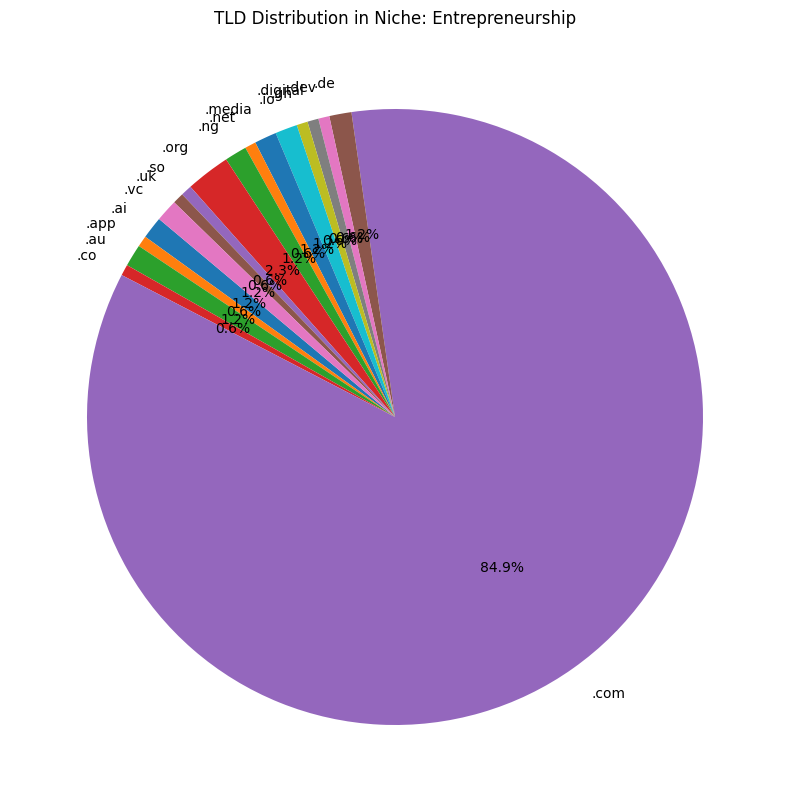

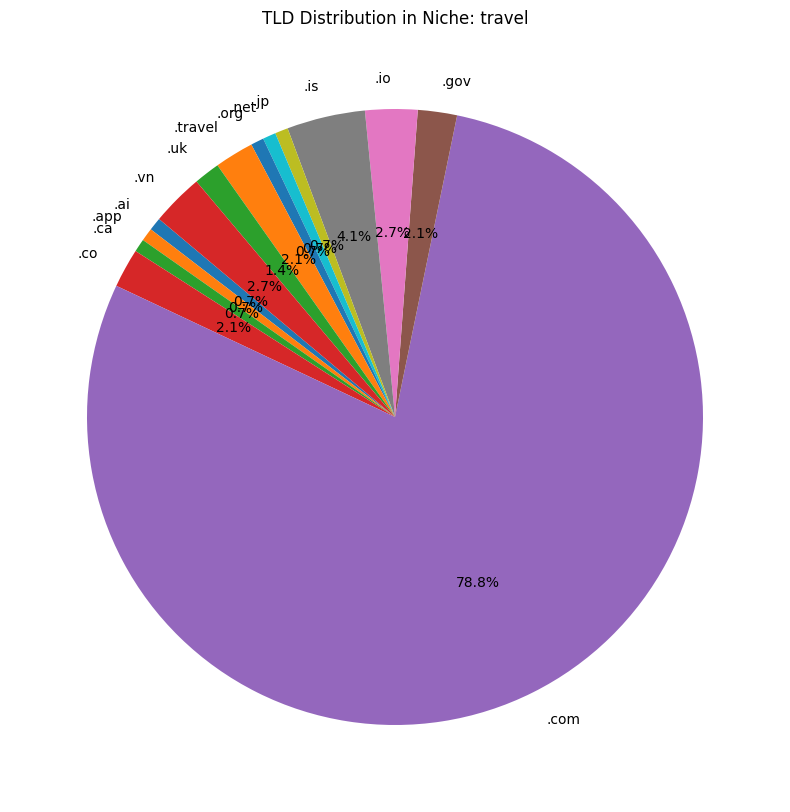

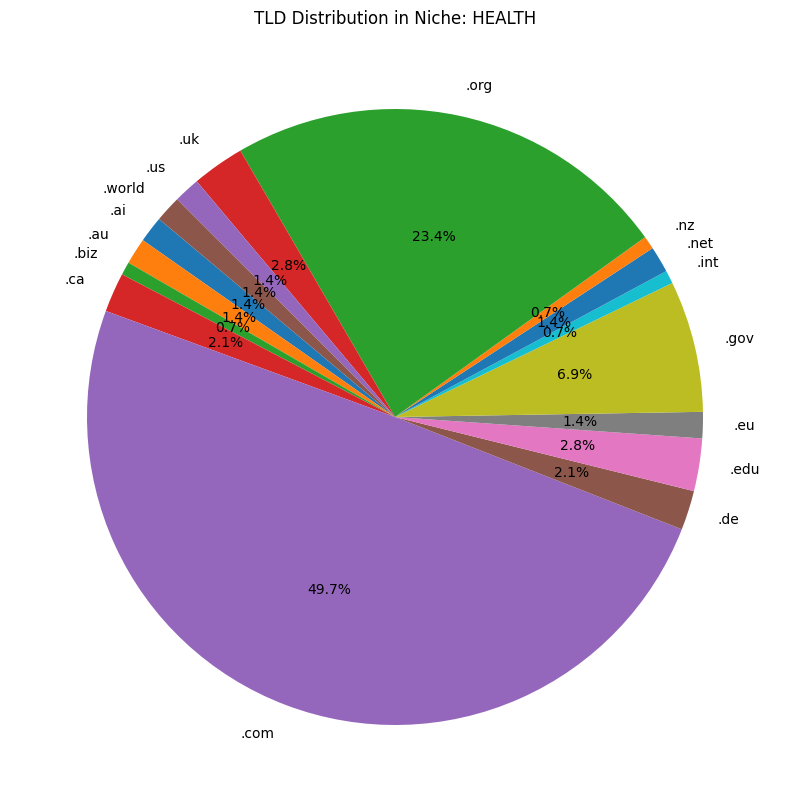

In [9]:
# ----------------------------
# Niche Analysis: Stats & Visualizations
# ----------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'niche' column exists in exploded
if "niche" not in exploded.columns:
    exploded["niche"] = "other"

# ----------------------------
# Top domains per niche
# ----------------------------
domain_by_niche = exploded.groupby(["niche", "domain_exploded"]).size().reset_index(name="count")
top_domains_per_niche = domain_by_niche.sort_values(["niche","count"], ascending=[True,False]).groupby("niche").head(10)

print("=== Top Domains per Niche ===")
display(top_domains_per_niche)

# ----------------------------
# TLD distribution per niche
# ----------------------------
tld_by_niche = exploded.groupby(["niche","_tld"]).size().reset_index(name="count")
tld_by_niche["pct"] = tld_by_niche.groupby("niche")["count"].transform(lambda x: x / x.sum() * 100)

print("=== TLD Distribution per Niche ===")
display(tld_by_niche)

# ----------------------------
# Average links per response per niche
# ----------------------------
avg_links_per_niche = grouped.groupby("niche")["_num_urls"].agg(["count","mean","median"]).sort_values("mean", ascending=False)
print("=== Avg Links per Niche ===")
display(avg_links_per_niche)

# ----------------------------
# Visualizations
# ----------------------------

# Bar charts: Top domains per niche
for niche in exploded["niche"].unique():
    data = top_domains_per_niche[top_domains_per_niche["niche"]==niche]
    if data.empty: continue
    plt.figure(figsize=(10,5))
    sns.barplot(data=data, x="domain_exploded", y="count", palette="viridis")
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Top Domains in Niche: {niche}")
    plt.ylabel("Count")
    plt.xlabel("Domain")
    plt.tight_layout()
    plt.show()

# Pie charts: TLD distribution per niche
for niche in exploded["niche"].unique():
    data = tld_by_niche[tld_by_niche["niche"]==niche]
    if data.empty: continue
    plt.figure(figsize=(10,10))
    plt.pie(data["count"], labels=data["_tld"], autopct="%1.1f%%", startangle=140)
    plt.title(f"TLD Distribution in Niche: {niche}")
    plt.show()